/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


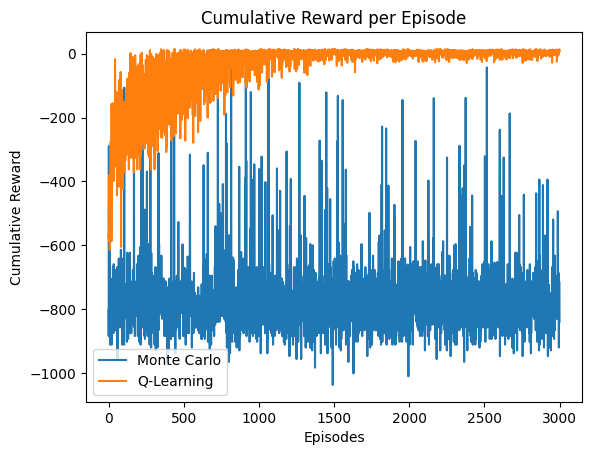

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import json

# Create the Taxi environment
env = gym.make("Taxi-v3")

# Hyperparameters for Monte Carlo
mc_alpha = 0.02
mc_gamma = 0.99

# Hyperparameters for Q-Learning
ql_alpha = 0.1
ql_gamma = 0.99
ql_epsilon = 0.1

# Number of episodes
num_episodes = 3000

# Initialize value functions
mc_V = np.zeros(env.observation_space.n)
ql_Q = np.zeros((env.observation_space.n, env.action_space.n))

# Function to save weights
def save_weights(mc_V, ql_Q):
    np.save("mc_V.npy", mc_V)
    np.save("ql_Q.npy", ql_Q)

# Monte Carlo algorithm
def monte_carlo(env, mc_V, alpha, gamma, num_episodes):
    returns = {state: [] for state in range(env.observation_space.n)}
    cumulative_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_states_actions_rewards = []
        done = False
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            episode_states_actions_rewards.append((state, action, reward))
            state = next_state

        G = 0
        visited_states = set()
        for state, action, reward in reversed(episode_states_actions_rewards):
            G = gamma * G + reward
            if state not in visited_states:
                returns[state].append(G)
                mc_V[state] = np.mean(returns[state])
                visited_states.add(state)

        cumulative_rewards.append(sum([x[2] for x in episode_states_actions_rewards]))

    return cumulative_rewards

# Q-Learning algorithm
def q_learning(env, ql_Q, alpha, gamma, epsilon, num_episodes):
    cumulative_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(ql_Q[state])

            next_state, reward, done, _ = env.step(action)
            best_next_action = np.argmax(ql_Q[next_state])
            ql_Q[state][action] = ql_Q[state][action] + alpha * (reward + gamma * ql_Q[next_state][best_next_action] - ql_Q[state][action])

            state = next_state
            episode_reward += reward

        cumulative_rewards.append(episode_reward)

    return cumulative_rewards

# Train Monte Carlo and Q-Learning
mc_rewards = monte_carlo(env, mc_V, mc_alpha, mc_gamma, num_episodes)
ql_rewards = q_learning(env, ql_Q, ql_alpha, ql_gamma, ql_epsilon, num_episodes)

# Save the trained weights
save_weights(mc_V, ql_Q)

# Plot cumulative rewards
plt.plot(range(num_episodes), mc_rewards, label="Monte Carlo")
plt.plot(range(num_episodes), ql_rewards, label="Q-Learning")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward per Episode")
plt.legend()
plt.show()
